In [1]:
import jax
from jax import lax, jit, vmap, random
import jax.numpy as jnp
import haiku as hk
import numpy as np
import optax
import string
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# ***Encoder Block***
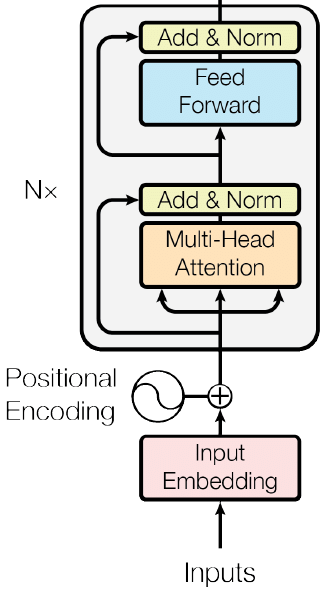

### ***1) Setting up a Toy Dataset*** 

In [2]:
with open("data/dormeur_du_val.txt", "r", encoding="utf-8") as f:
    text = f.read().lower()
wo_punct = [letter for letter in text if letter not in string.punctuation]
tokens = "".join(wo_punct).split()
tokens[:9]

['cest', 'un', 'trou', 'de', 'verdure', 'où', 'chante', 'une', 'rivière']

In [3]:
SEQ_LEN = 10
VOCAB_SIZE = len(set(tokens))
EMBED_DIM = 64
BATCH_SIZE = 32
SEED = 17
key = random.PRNGKey(SEED)

In [4]:
def collect_sequences(key:random.PRNGKey, data:list, seq_len:int, n_seq:int):
    """
    Samples n_seq random offsets and returns the same number of token sequences
    of length seq_len 
    """
    start_indexes = random.randint(key, (n_seq,), 0, len(data)-seq_len)
    return [data[start_indexes[i]: start_indexes[i] + seq_len] for i in range(n_seq)]

sequences = collect_sequences(key, tokens, SEQ_LEN, BATCH_SIZE)

In [5]:
token_to_indices = {token:idx for idx, token in enumerate(set(tokens))}
encode_tokens = lambda sequence: [token_to_indices[token] for token in sequence]
encoded_sequences = jnp.array(list(map(encode_tokens, sequences)))
encoded_sequences.shape

(32, 10)

In [6]:
def embed_fn(tokenized_sequences):
    """
    creates a learnable lookup table of size vocab_size x embedding_dim
    """
    embedding_layer = hk.Embed(VOCAB_SIZE, embed_dim=EMBED_DIM)
    return embedding_layer(tokenized_sequences)

# Haiku transform enables the init and apply functions
# without_apply_rng specifies that apply doesn't need a random key
embed = hk.without_apply_rng(hk.transform(embed_fn))

# param initialization
params = embed.init(key, encoded_sequences)
embeddings = embed.apply(params, encoded_sequences)
embeddings.shape

(32, 10, 64)

### ***2) Positional Encodings*** 
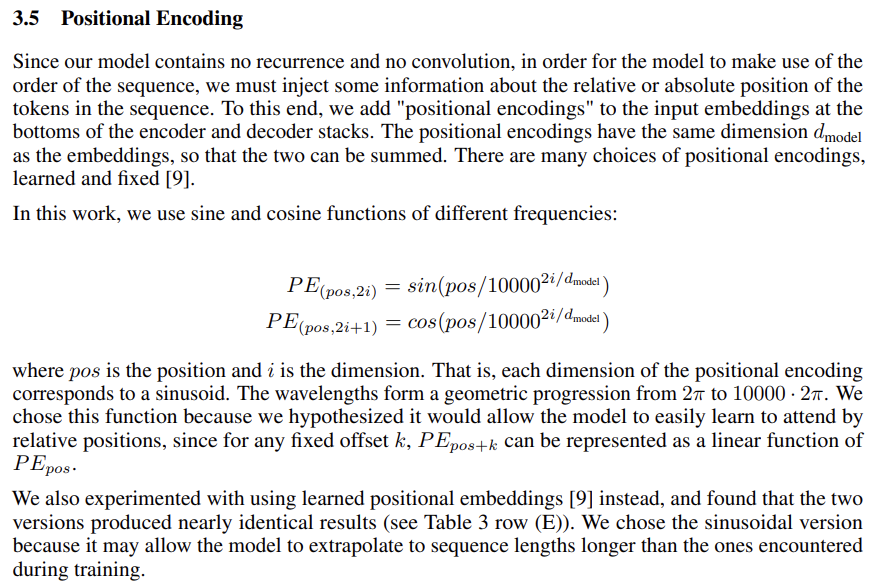

### ***2) Positional Encodings*** 

In [7]:
@jit
def positional_encoding(pos:int, dim:int, embed_dim:int):
    """
    Returns a single encoding for a single token
    """
    def _even_encoding():
        return jnp.sin(pos / (jnp.power(10_000, 2*dim/embed_dim)))
    
    def _odd_encoding():
        return jnp.cos(pos / (jnp.power(10_000, 2*dim/embed_dim)))
    
    is_even = (dim % 2 == 0)
    return lax.cond(
        is_even,
        _even_encoding,
        _odd_encoding
    )

@jit
def batched_positional_encoding(pos:int, dim:jnp.array, embed_dim:int):
    """
    Returns embed_dim encodings for a single token or a sequence of tokens
    """
    return vmap(
        positional_encoding,
        in_axes=(None, 0, None),
        out_axes=(1)
    )(pos, dim, embed_dim)

In [8]:
batch_pos_encoding = batched_positional_encoding(jnp.arange(SEQ_LEN), jnp.arange(EMBED_DIM), EMBED_DIM)

In [9]:
positional_embeddings = embeddings + batch_pos_encoding
positional_embeddings.shape

(32, 10, 64)

In [10]:
titles = ["Positional Encodings", "Word Embeddings", "Positional Encodings + Embeddings"]
fig = make_subplots(rows=3, cols=1, subplot_titles=titles, shared_xaxes=True)

for row, values in enumerate([batch_pos_encoding, embeddings[0], positional_embeddings[0]]):
    fig.add_trace(
        go.Heatmap(z=values, colorscale="Viridis", showscale=False),row=row+1, col=1, 
    )
    fig.update_yaxes(autorange="reversed", row=row+1, col=1)
fig.update_yaxes(title_text="Token Position", row=2, col=1)
fig.update_xaxes(title_text="Embedding Dimension", row=row+1, col=1)
fig.update_layout(title_text="Adding Positional Encoding to Word Embeddings", height=700)

fig.show()

### ***3) Multi-Head Self-Attention*** 

In [11]:
N_HEADS = 4
D_K = int(EMBED_DIM / N_HEADS)

In [12]:
def init_attention_weights(key, embed_dim, d_k, n_heads, scale=1e-2):
    """
    Initializes the Q, K, V weight vectors using the random normal distr
    These vectors have shape (N_HEADS, EMBED_DIM, D_K)
    """
    key, subkey = random.split(key)
    # QW, KW and VW have shape (embed_dim, d_k)
    # d_k is often set to embed_dim / n_heads
    weights = random.normal(subkey, (3, embed_dim, d_k, n_heads)) #* scale
    WQ, WK, WV = weights
    WQ, WK, WV = map(lambda x: x.transpose(2, 0 ,1), [WQ, WK, WV]) # (n_heads, embed_dim, d_k)
    return WQ, WK, WV, subkey

WQ, WK, WV, key = init_attention_weights(key, EMBED_DIM, D_K, N_HEADS)
jax.tree_map(lambda x: x.shape, [WQ, WK, WV])

[(4, 64, 16), (4, 64, 16), (4, 64, 16)]

In [13]:
@jit
def get_Q_K_V_matrices(QW, KW, VW, positional_embeddings):
    """
    Returns the Querries, Keys and Values as matrices of
    shape (BATCH_SIZE, SEQ_LEN, D_K)
    """
    return jax.tree_map(lambda x: jnp.matmul(positional_embeddings, x), [QW, KW, VW])
     

@jit
def get_multihead_Q_K_V_matrices(QK, KW, VW, positional_embeddings):
    return vmap(
        get_Q_K_V_matrices,
        in_axes=(0, 0, 0, None)
        )(QK, KW, VW, positional_embeddings)

Q, K, V = get_multihead_Q_K_V_matrices(WQ, WK, WV, positional_embeddings)
jax.tree_map(lambda x: x.shape, [Q, K, V])

[(4, 32, 10, 16), (4, 32, 10, 16), (4, 32, 10, 16)]

In [14]:
@jit
def attention(Q, K, V, d_k):
    attention_score = jnp.matmul(Q, K.transpose(0, 2, 1)) # transpose to (N_HEADS, BATCH_SIZE, D_K, SEQ_LEN)
    scaled_attention = jax.nn.softmax(attention_score / jnp.sqrt(d_k), axis=-1) # softmax along the SEQ_LEN dimension
    return jnp.matmul(scaled_attention, V)

@jit
def mulithead_attention(Q, K, V, d_k):
    return vmap(
        attention,
        in_axes=(0, 0, 0, None) # iterate over the heads
        )(Q, K, V, d_k)

attention_matrix = mulithead_attention(Q, K, V, D_K)
print(attention_matrix.shape)
px.imshow(attention_matrix[0, 0], title="Attention Matrix for head 0, batch 0", labels=dict(x="D_K", y="SEQ_LEN"), color_continuous_scale="VIRIDIS")

(4, 32, 10, 16)


In [15]:
# transpose the matrix to (BATCH_SIZE, SEQ_LEN, N_HEADS, D_K)
# so that N_HEADS and D_K are trailing, call reshape to concatenate the N_HEADS D_K vectors
attention_matrix = attention_matrix.transpose(1, 2, 0, 3).reshape(BATCH_SIZE, SEQ_LEN, -1)
print(attention_matrix.shape)
px.imshow(attention_matrix[0], title="Concatenated Attention Matrix for one batch", labels=dict(x="EMBED_DIM", y="SEQ_LEN"), color_continuous_scale="VIRIDIS")

(32, 10, 64)


#### ***3.5) Post-Attention Linear Layer*** 

In [16]:
@hk.transform
def linear_layer(x):
    return hk.Linear(EMBED_DIM)(x)

params = linear_layer.init(key, attention_matrix)
print(jax.tree_map(lambda x: x.shape, params))

linear_attention = linear_layer.apply(params, None, attention_matrix)
print(linear_attention.shape)
px.imshow(linear_attention[0], title="Output of the Linear Layer", labels=dict(x="EMBED_DIM", y="SEQ_LEN"), color_continuous_scale="VIRIDIS")

{'linear': {'b': (64,), 'w': (64, 64)}}
(32, 10, 64)


### ***4) Residual Connection and Layer Norm*** 

In [17]:
residual_connection = linear_attention + positional_embeddings
px.imshow(residual_connection[0], title="Output of the Residual Connection", labels=dict(x="EMBED_DIM", y="SEQ_LEN"), color_continuous_scale="VIRIDIS")

>***Layer Normalization is a type of normalization technique designed to improve the training of deep neural networks. While Batch Normalization normalizes across the batch dimension, Layer Normalization normalizes across the feature dimension.***


1) Compute Mean and Variance (assuming $d_m$ is the feature dimension):
$$\mu = {{1}\over{d_m}}\sum_{i=1}^{d_m} X_i$$
$$\sigma^2 = {{1}\over{d_m}}\sum_{i=1}^{d_m} (X_i - \mu)^2$$

2) Normalize:
$$X_{norm} = {{X - \mu}\over{\sqrt{\sigma^2+\epsilon}}}$$

3) Scale and shift (with $\gamma$ and $\beta$ learned parameters):
$$Y = \gamma * X_{\text{norm}} + \beta$$

In [18]:
@hk.transform
def layer_norm(x, name:str, epsilon=1e-6):
    # computing the mean and variance of the features
    # assuming that the embedding dimension comes last
    means, vars = jnp.mean(x, axis=-1), jnp.var(x, axis=-1)
    normalized = (x - jnp.expand_dims(means, -1)) / jnp.sqrt(jnp.expand_dims(vars, -1) + epsilon)

    gamma = hk.get_parameter(f"gamma_{name}", shape=(x.shape[-1],), init=jnp.ones)
    beta = hk.get_parameter(f"beta_{name}", shape=(x.shape[-1],), init=jnp.zeros)

    return gamma * normalized + beta

post_attention_LN_params = {
    "name":"post_attention",
    "x":residual_connection
}

params = layer_norm.init(key, **post_attention_LN_params)
normalized = layer_norm.apply(params, None, **post_attention_LN_params)
print(normalized.shape)
px.imshow(normalized[0], title="Output of the Layer Normalization", labels=dict(x="EMBED_DIM", y="SEQ_LEN"), color_continuous_scale="VIRIDIS")

(32, 10, 64)


### ***5) Positional Feed-Forward Net*** 

In [19]:
@hk.transform
def feed_forward_net(x, embed_dim, hidden_dim):
    """
    Simple feed-forward network with two linear layer
    and relu activation
    FFN(x) = max(0, xW1 + b1)W2 + b2
    """
    x = hk.Linear(hidden_dim)(x)
    x = jax.nn.relu(x)
    x = hk.Linear(embed_dim)(x)
    return x

In [20]:
model_params = {
    "x":normalized,
    "embed_dim":EMBED_DIM,
    "hidden_dim":256
}
params = feed_forward_net.init(key, **model_params)
print(jax.tree_map(lambda x: x.shape, params))

ffn = feed_forward_net.apply(params, None, **model_params)
post_ffn_res = ffn + linear_attention

{'linear': {'b': (256,), 'w': (64, 256)}, 'linear_1': {'b': (64,), 'w': (256, 64)}}


In [21]:
px.imshow(ffn[0], title="Output of the Feed Forward Network", labels=dict(x="EMBED_DIM", y="SEQ_LEN"), color_continuous_scale="VIRIDIS")

In [22]:
px.imshow(post_ffn_res[0], title="Output of the Feed Forward Network + Residual Connection (Linear Attention)", labels=dict(x="EMBED_DIM", y="SEQ_LEN"), color_continuous_scale="VIRIDIS")

In [23]:
post_FeedForward_LN_params = {
    "name":"post_feed_forward",
    "x":post_ffn_res
}

params = layer_norm.init(key, **post_FeedForward_LN_params)
normalized = layer_norm.apply(params, None, **post_FeedForward_LN_params)
print(normalized.shape)
px.imshow(normalized[0], title="Output of the Layer Normalization, after Feed Forward Network and Residual Connection", labels=dict(x="EMBED_DIM", y="SEQ_LEN"), color_continuous_scale="VIRIDIS")

(32, 10, 64)
